In [25]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn import preprocessing

from sqlalchemy import create_engine

from matplotlib import pylab as plt
import seaborn as sns

plt.style.use("bmh")

import arviz as az

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [26]:
%watermark -v -d -t -z -u -r -iv

matplotlib.pylab 1.17.3
numpy            1.17.3
scipy            1.3.1
seaborn          0.9.0
arviz            0.6.0
sklearn          0.22
pandas           0.25.2
last updated: 2020-01-06 11:24:51 PST 

CPython 3.7.4
IPython 7.9.0
Git repo: git@github.com:clausherther/nfl-analysis.git


In [27]:
url = "bigquery://nfl"
key_file_path = "/Users/claus/dev/bigquery-keys/nfl-pbp-bigquery-service-account.json"
engine = create_engine(url, credentials_path=key_file_path, echo=True)

In [28]:
query = "select * from analysis.xa_field_goals"
with engine.connect() as con:
    df = pd.read_sql(query, con)

2020-01-06 11:24:52,703 INFO sqlalchemy.engine.base.Engine select * from analysis.xa_field_goals
2020-01-06 11:24:52,703 INFO sqlalchemy.engine.base.Engine {}


In [29]:
df.head()

,play_key,game_date,game_id,play_id,season_nbr,season_type_code,season_code,quarter,down,play_type,...,kick_distance_yards,is_within_goal_line,field_goal_result,is_field_goal_success,field_goals,successful_field_goals,kick_angle_horizontal,kick_angle_vertical,kick_angle_horizontal_degrees,kick_angle_vertical_degrees
0,210b18c13f0bac908eddce02ed54331a,2015-09-10,2015091000,285,2015,REG,REG2015,1,4,field_goal,...,44.0,False,missed,False,1,0,0.136807,0.259187,7.838475,14.850338
1,972bc368c29d6c173827b5a3db7cd384,2015-09-10,2015091000,1208,2015,REG,REG2015,2,4,field_goal,...,46.0,False,missed,False,1,0,0.131124,0.248386,7.512839,14.231458
2,be0fe604388ace9230c0d0e86a2f047f,2015-09-10,2015091000,1852,2015,REG,REG2015,2,4,field_goal,...,44.0,False,made,True,1,1,0.136807,0.259187,7.838475,14.850338
3,9947063607db959ca88d44812ab88363,2015-09-10,2015091000,2879,2015,REG,REG2015,4,4,field_goal,...,24.0,True,made,True,1,1,0.237672,0.452475,13.617600,25.924902
4,997a7e9ccc32cc4471a18b22f70490a2,2011-08-15,2011081551,301,2011,PRE,PRE2011,1,4,field_goal,...,33.0,False,made,True,1,1,0.179119,0.339821,10.262784,19.470302


In [33]:
df["game_date"] = pd.to_datetime(df["game_date"])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13579 entries, 0 to 13578
Data columns (total 28 columns):
play_key                         13579 non-null object
game_date                        13579 non-null datetime64[ns]
game_id                          13579 non-null int64
play_id                          13579 non-null int64
season_nbr                       13579 non-null int64
season_type_code                 13579 non-null object
season_code                      13579 non-null object
quarter                          13579 non-null int64
down                             13579 non-null int64
play_type                        13579 non-null object
home_team_code                   13579 non-null object
away_team_code                   13579 non-null object
off_team_code                    13579 non-null object
def_team_code                    13579 non-null object
kicker_player_id                 13579 non-null object
kicker_player_name               13576 non-null object
yards_to

In [35]:
df.to_hdf("data/field_goals.hd5", "field_goals")

Baseline Field Goal % is:

In [9]:
df["successful_field_goals"].sum()/df["field_goals"].sum()

0.8338611090654687

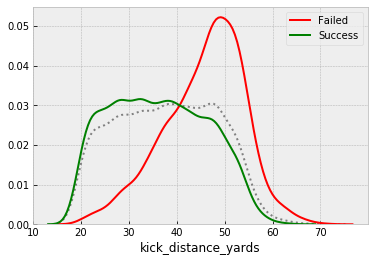

In [10]:
sns.distplot(df["kick_distance_yards"], bins=30, hist=False, color="grey", kde_kws={"linestyle":"dotted"})
sns.distplot(df[df["is_field_goal_success"]==False]["kick_distance_yards"], bins=30, hist=False, color="red", label="Failed");
sns.distplot(df[df["is_field_goal_success"]==True]["kick_distance_yards"], bins=30, hist=False, color="green", label="Success");

In [11]:
df_grp_yards = pd.DataFrame(
    df
#      .query("yardline_100 < 47")
     .groupby("yardline_100")[["field_goals", "successful_field_goals"]]
     .sum()
     .reset_index()
    ,
#     columns=["yardline_100", "field_goals_success_percent"]
)
df_grp_yards["field_goals_success_percent"] = df_grp_yards["successful_field_goals"]/df_grp_yards["field_goals"]

In [17]:
df_grp_yards.head(10)

,yardline_100,field_goals,successful_field_goals,field_goals_success_percent
0,1,144,144,1.000000
1,2,261,259,0.992337
2,3,302,296,0.980132
3,4,321,315,0.981308
4,5,373,367,0.983914
5,6,298,285,0.956376
6,7,351,347,0.988604
7,8,334,322,0.964072
8,9,360,347,0.963889
9,10,404,386,0.955446


In [13]:
df_grp_yards["successful_field_goals"].sum()/df_grp_yards["field_goals"].sum()

0.8338611090654687

In [14]:
yard_int = 5
yard_lines_5 = list(range(yard_int, 100+yard_int, yard_int))
yard_lines = list(range(1, 100+1, 1))

In [15]:
x_yards = df_grp_yards["yardline_100"]
y_probs = df_grp_yards["field_goals_success_percent"]

In [21]:
df_yard_lines = pd.DataFrame(yard_lines, columns=["yardline_100"])

In [22]:
df_grp_yards_expanded = df_yard_lines.merge(df_grp_yards, how="left").fillna(0)

In [23]:
df_grp_yards_expanded.shape

(100, 4)

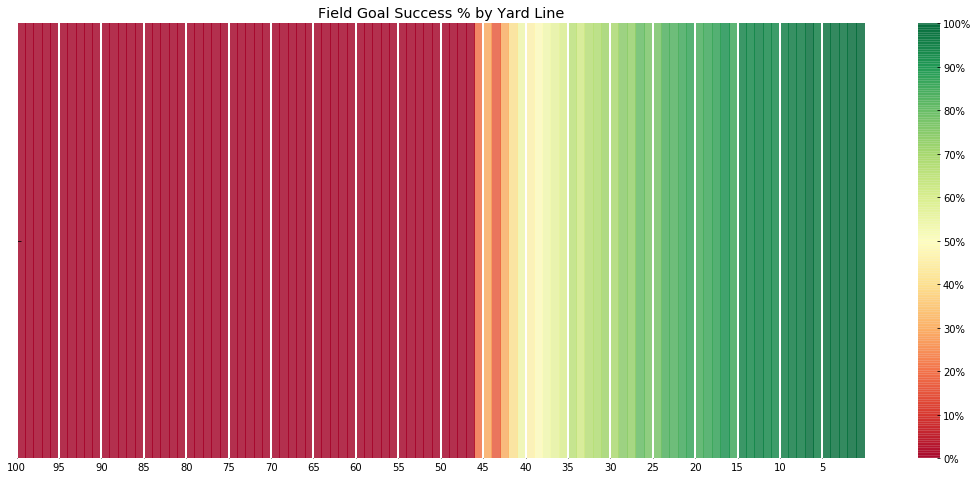

In [24]:
_, ax = plt.subplots(1, 1, figsize=(19, 8))

fmt=".0%"
sns.heatmap(
        df_grp_yards_expanded[["field_goals_success_percent"]].T.values,
        cmap="RdYlGn", 
        cbar=True,
#         vmin=0, vmax=1,
        alpha=.8,
        ax=ax
    )
# yards_10
ax.set_xticks(yard_lines_5)
ax.set_xticklabels(yard_lines_5)
ax.set_yticklabels("")
ax.vlines(yard_lines_5, 0, 1, linestyles="solid", alpha=1, color="white")
cbar = ax.collections[0].colorbar
vals = np.arange(0, 1.1, 0.1)
cbar.set_ticks(vals)
cbar.set_ticklabels([f"{x:,.0%}" for x in vals])

ax.set_xlim(ax.get_xlim()[1], 0)
ax.set_title("Field Goal Success % by Yard Line");
# plt.tight_layout();